In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
from PIL import Image

# Preprocessing packages
from sklearn.model_selection import train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer # Xử lý missing values
from sklearn.pipeline import Pipeline
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor
from skimage.feature import hog
from tqdm import tqdm
from scipy import stats

# Mô hình ML
from sklearn.svm import SVC

# Đánh giá mô hình
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

RANDOM_SEED = 42
SIZE = 32
np.random.seed(RANDOM_SEED)

# **Read data**

In [ ]:
skin_df = pd.read_csv("/content/drive/MyDrive/Capstone 1 Data/HAM10000_metadata.csv")
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [ ]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


# Xử lý missing values

In [ ]:
print("True NaNs per column:")
skin_df.isna().sum()

True NaNs per column:


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


In [ ]:
# Check blank strings and common placeholders on object columns
placeholders = {"", " ", "?", "NA", "N/A", "na", "Unknown", "unknown"}
for col in ["sex", "localization", "dx", "dx_type", "lesion_id", "image_id"]:
    if skin_df[col].dtype == "O":
        blanks = skin_df[col].astype(str).str.strip().eq("").sum()
        fake_missing = skin_df[col].isin(placeholders).sum()
        print(f"{col:>13} -> blank:'' count = {blanks}, placeholder count = {fake_missing}")

          sex -> blank:'' count = 0, placeholder count = 57
 localization -> blank:'' count = 0, placeholder count = 234
           dx -> blank:'' count = 0, placeholder count = 0
      dx_type -> blank:'' count = 0, placeholder count = 0
    lesion_id -> blank:'' count = 0, placeholder count = 0
     image_id -> blank:'' count = 0, placeholder count = 0


In [ ]:
print("NaNs BEFORE (age):", int(skin_df["age"].isna().sum()))
_age_imp = SimpleImputer(strategy="median")
skin_df["age"] = _age_imp.fit_transform(skin_df[["age"]]).ravel().astype(float)
print("NaNs AFTER  (age):", int(skin_df["age"].isna().sum()))

age_imputer = _age_imp

NaNs BEFORE (age): 57
NaNs AFTER  (age): 0


In [ ]:
# Cột cần xử lý
cat_cols = ["sex", "localization"]

# Missing values
placeholders = {"", " ", "?",
                "na", "n/a", "none",
                "null", "unknown", "unk",
                "nan", "NA", "N/A", "Unknown"}

def _norm(s):
    """
    Normalize string:
    - Ép về string, bỏ khoảng trắng ở 2 đầu.
    - Thay "" bằng NaN tạm thời.
    - Đưa về chữ thường để xử lý dễ hơn.
    """
    return s.astype(str).str.strip().replace({"": np.nan}).str.lower()

for c in cat_cols:
    print(f"[{c}] TRƯỚC -> số giá trị khác nhau:", skin_df[c].nunique(),
          "| ví dụ:", skin_df[c].value_counts(dropna=False).head(3).to_dict())

# Bước 1: Normalize và đổi placeholders thành NaN
for c in cat_cols:
    skin_df[c] = _norm(skin_df[c])
    skin_df.loc[skin_df[c].isin({p.lower() for p in placeholders}), c] = np.nan

# Bước 2: Impute lại NaN bằng hằng số "unknown" cho các cột phân loại
_cat_imp = SimpleImputer(strategy="constant", fill_value="unknown")
skin_df[cat_cols] = _cat_imp.fit_transform(skin_df[cat_cols])

# Bước 3: Đảm bảo kiểu dữ liệu là string
for c in cat_cols:
    skin_df[c] = skin_df[c].astype(str)

# Summary sau khi xử lý
for c in cat_cols:
    print(f"[{c}] SAU  -> số giá trị khác nhau:", skin_df[c].nunique(),
          "| ví dụ:", skin_df[c].value_counts(dropna=False).head(3).to_dict())

cat_imputer = _cat_imp

[sex] TRƯỚC -> số giá trị khác nhau: 3 | ví dụ: {'male': 5406, 'female': 4552, 'unknown': 57}
[localization] TRƯỚC -> số giá trị khác nhau: 15 | ví dụ: {'back': 2192, 'lower extremity': 2077, 'trunk': 1404}
[sex] SAU  -> số giá trị khác nhau: 3 | ví dụ: {'male': 5406, 'female': 4552, 'unknown': 57}
[localization] SAU  -> số giá trị khác nhau: 15 | ví dụ: {'back': 2192, 'lower extremity': 2077, 'trunk': 1404}


In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# Biển đổi cột dx thành dx_dict (theo mapping dx_dict)

In [ ]:
# Normalize cột dx
skin_df["dx"] = skin_df["dx"].astype(str).str.strip().str.lower()

dx_dict = {
    "akiec": "Actinic keratoses/Bowen's disease (intraepithelial carcinoma)",
    "bcc":   "Basal cell carcinoma",
    "bkl":   "Benign keratosis-like lesions",
    "df":    "Dermatofibroma",
    "mel":   "Melanoma",
    "nv":    "Melanocytic nevi",
    "vasc":  "Vascular lesions",
}

# Kiểm tra các giá trị 'dx' hiện có
print("dx uniques BEFORE:", sorted(skin_df["dx"].unique().tolist()))

# Biến đổi thành cột diagnosis
skin_df["diagnosis"] = skin_df["dx"].map(dx_dict)

# Cảnh báo nếu có giá trị chưa map
unmapped = skin_df["diagnosis"].isna()
if unmapped.any():
    missing_vals = sorted(skin_df.loc[unmapped, "dx"].unique().tolist())
    print("Chưa map các giá trị dx sau:", missing_vals)
    # Để tránh NaN khi LabelEncoder, thay bằng 'Unknown'
    skin_df.loc[unmapped, "diagnosis"] = "Unknown"

# Sắp xếp lại thứ tự
ordered_labels = [
    "Actinic keratoses/Bowen's disease (intraepithelial carcinoma)",
    "Basal cell carcinoma",
    "Benign keratosis-like lesions",
    "Dermatofibroma",
    "Melanoma",
    "Melanocytic nevi",
    "Vascular lesions",
    "Unknown",
]
skin_df["diagnosis"] = pd.Categorical(
    skin_df["diagnosis"], categories=ordered_labels, ordered=False
)

print("\nDiagnosis value counts:")
print(skin_df["diagnosis"].value_counts(dropna=False))

dx uniques BEFORE: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

Diagnosis value counts:
diagnosis
Melanocytic nevi                                                 6705
Melanoma                                                         1113
Benign keratosis-like lesions                                    1099
Basal cell carcinoma                                              514
Actinic keratoses/Bowen's disease (intraepithelial carcinoma)     327
Vascular lesions                                                  142
Dermatofibroma                                                    115
Unknown                                                             0
Name: count, dtype: int64


In [ ]:
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,Benign keratosis-like lesions
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,Benign keratosis-like lesions
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Benign keratosis-like lesions
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,Benign keratosis-like lesions


# Label Encoder cho dx

In [ ]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization                      diagnosis  label  
1617             face                       Melanoma      4  
8128  lower extremity               Melanocytic nevi      5  
2168             back                       Mel

In [ ]:
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Benign keratosis-like lesions,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,Benign keratosis-like lesions,2


# OneHotEncoder cho cột sex và localization

In [ ]:
cols_to_encode = ['sex', 'localization']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_transformed = ohe.fit_transform(skin_df[cols_to_encode])
ohe_cols = []
for col, cats in zip(cols_to_encode, ohe.categories_):
    ohe_cols.extend([f"{col}_ohe_{c}" for c in cats])

ohe_df = pd.DataFrame(ohe_transformed, columns=ohe_cols, index=skin_df.index)
skin_df = pd.concat([skin_df, ohe_df], axis=1)

In [ ]:
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis,label,sex_ohe_female,...,localization_ohe_face,localization_ohe_foot,localization_ohe_genital,localization_ohe_hand,localization_ohe_lower extremity,localization_ohe_neck,localization_ohe_scalp,localization_ohe_trunk,localization_ohe_unknown,localization_ohe_upper extremity
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions,2,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,Benign keratosis-like lesions,2,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Benign keratosis-like lesions,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,Benign keratosis-like lesions,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   lesion_id                         10015 non-null  object  
 1   image_id                          10015 non-null  object  
 2   dx                                10015 non-null  object  
 3   dx_type                           10015 non-null  object  
 4   age                               10015 non-null  float64 
 5   sex                               10015 non-null  object  
 6   localization                      10015 non-null  object  
 7   diagnosis                         10015 non-null  category
 8   label                             10015 non-null  int64   
 9   sex_ohe_female                    10015 non-null  float64 
 10  sex_ohe_male                      10015 non-null  float64 
 11  sex_ohe_unknown                   10015 non-null  floa

# Hiển thị data

/tmp/ipython-input-3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


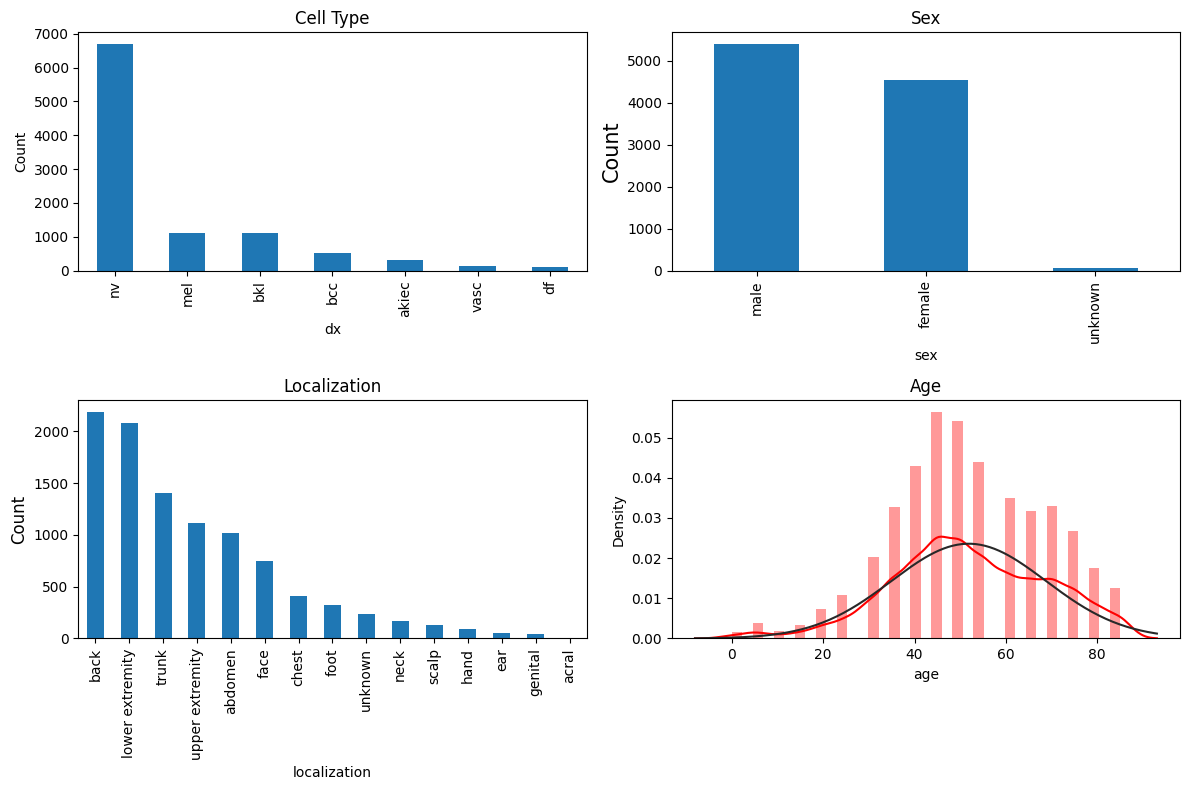

In [ ]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

# Phân phối dữ liệu thành nhiều class khác nhau

In [ ]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


# Thêm đường dẫn ảnh cho data

In [ ]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/Capstone 1 Data', '*', '*.jpg'))}

In [ ]:
# Xác định path của ảnh và thêm vào một cột mới của dataset
skin_df['path'] = skin_df['image_id'].map(image_path.get)

# Kiểm tra xem có image_id nào không tìm thấy path sau khi map không
missing_paths = skin_df[skin_df['path'].isnull()]
if not missing_paths.empty:
    print(f"Warning: {len(missing_paths)} images not found in the specified directories. Example image_ids: {missing_paths['image_id'].tolist()[:5]}")
    # Loại bỏ các hàng có path là None để tránh lỗi khi đọc ảnh
    skin_df = skin_df.dropna(subset=['path']).reset_index(drop=True)
    print(f"Removed {len(missing_paths)} rows with missing image paths.")
else:
    print("All image paths found successfully.")

All image paths found successfully.


In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis,label,sex_ohe_female,...,localization_ohe_foot,localization_ohe_genital,localization_ohe_hand,localization_ohe_lower extremity,localization_ohe_neck,localization_ohe_scalp,localization_ohe_trunk,localization_ohe_unknown,localization_ohe_upper extremity,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,/content/drive/MyDrive/Capstone 1 Data/HAM1000...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,/content/drive/MyDrive/Capstone 1 Data/HAM1000...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,/content/drive/MyDrive/Capstone 1 Data/HAM1000...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,/content/drive/MyDrive/Capstone 1 Data/HAM1000...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Capstone 1 Data/HAM1000...


# Load ảnh

In [ ]:
def load_images(image_paths, size=SIZE):
    n_images = len(image_paths)
    images = np.zeros((n_images, size * size), dtype=np.float32)

    for i, path in enumerate(tqdm(image_paths, desc="Loading images")):
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError("Image not loaded correctly")
            img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
            images[i] = img.flatten()
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            images[i] = np.zeros(size * size, dtype=np.float32)

    return images

image_paths = skin_df['path'].tolist()
X_gray = load_images(image_paths, size=SIZE)

skin_df['image'] = [x.reshape(SIZE, SIZE) for x in X_gray]

Loading images: 100%|██████████| 10015/10015 [46:42<00:00,  3.57it/s]


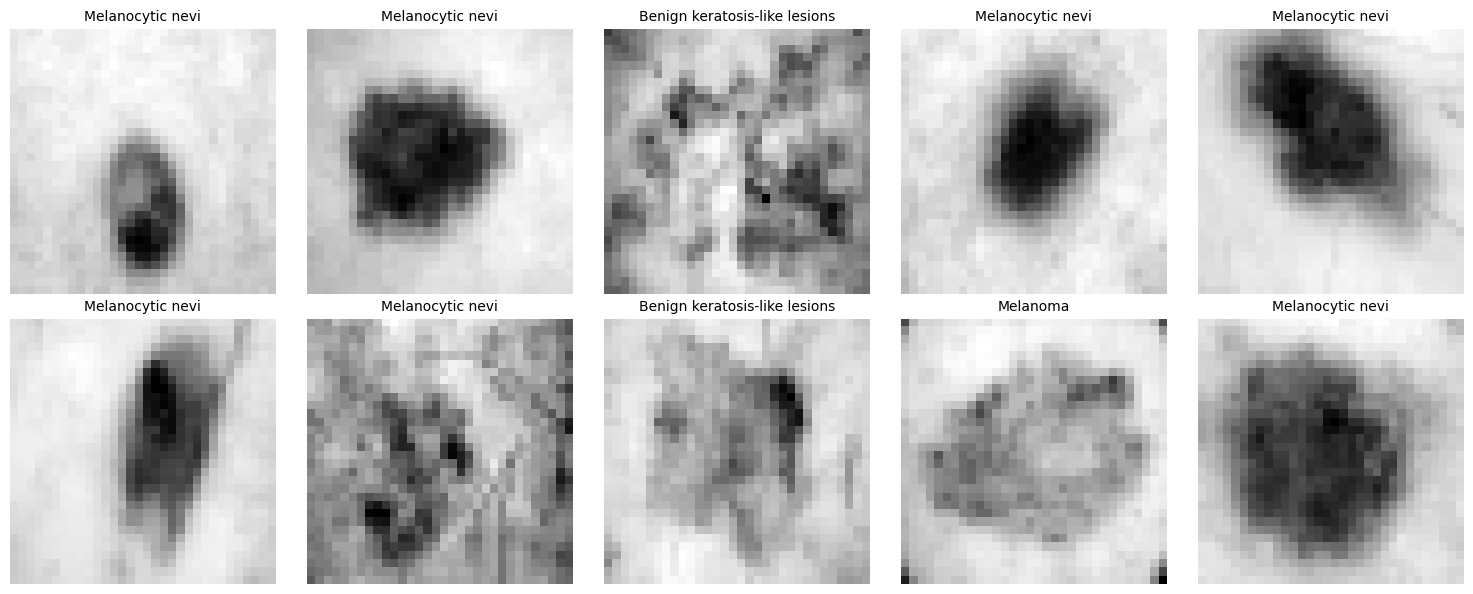

In [ ]:
# Hiển thị vài ảnh ngẫu nhiên ở dạng grayscale
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
random_indices = np.random.choice(len(skin_df), size=10, replace=False)
for i, idx in enumerate(random_indices):
    img = skin_df.iloc[idx]['image']
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(skin_df.iloc[idx]["diagnosis"], fontsize=10)
    axes[i].axis("off")
plt.tight_layout()
plt.show()

# Trích xuất đặc trưng của ảnh

In [ ]:
def _lbp_hist(gray, P=8, R=1):
    """
    Compute Local Binary Pattern histogram.
    """
    lbp = local_binary_pattern(gray, P=P, R=R, method='uniform')
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins), density=True)
    return hist.astype(np.float32)

def _glcm_props(gray, distances=(1, 2, 3), angles=(0, np.pi/4, np.pi/2, 3 * np.pi/4)):
    """
    Compute GLCM properties for grayscale image.
    """
    g8 = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    M = graycomatrix(g8, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    props = ['contrast', 'homogeneity', 'energy', 'correlation', 'dissimilarity']
    feats = [graycoprops(M, p).ravel() for p in props]
    return np.concatenate(feats).astype(np.float32)

def _hu_moments(gray):
    """
    Compute Hu moments for grayscale image.
    """
    m = cv2.moments(gray)
    hu = cv2.HuMoments(m).flatten()
    return (-np.sign(hu) * np.log10(np.abs(hu) + 1e-12)).astype(np.float32)

def _gabor_bank(gray, thetas=(0, np.pi/4, np.pi/2, 3 * np.pi/4), freqs=(0.1, 0.2, 0.3)):
    """
    Compute Gabor filter features for grayscale image.
    """
    g = gray.astype(np.float32) / 255.0
    feats = []
    for th in thetas:
        for f in freqs:
            real, _ = gabor(g, frequency=f, theta=th)
            feats.extend([real.mean(), real.std()])
    return np.array(feats, dtype=np.float32)

def _hog_features(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    """
    Compute HOG features for grayscale image.
    """
    gray = gray.astype(np.float32) / 255.0  # Normalize to [0, 1] for HOG
    return hog(
        gray, orientations=9,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=False
    ).astype(np.float32)

def _intensity_stats(gray):
    """
    Compute mean and standard deviation of pixel intensities.
    """
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)
    return np.array([mean_intensity, std_intensity], dtype=np.float32)

def extract_features_one(gray, size):
    """
    Extract features for a single grayscale image.

    Parameters:
    - gray: Flattened grayscale image (1D array of length size*size)
    - size: Image size (e.g., SIZE from global variable)

    Returns:
    - 1D numpy array of features (LBP: 10, GLCM: 60, Hu: 7, Gabor: 24, HOG: variable, Intensity: 2)
    """
    gray = gray.reshape(size, size)  # Reshape to 2D
    f = [
        _lbp_hist(gray),        # 10 dims
        _glcm_props(gray),      # 60 dims (3 distances * 4 angles * 5 properties)
        _hu_moments(gray),      # 7 dims
        _gabor_bank(gray),      # 24 dims (4 thetas * 3 freqs * 2 stats)
        _hog_features(gray),    # Variable dims (e.g., ~378 for 32x32 with default params)
        _intensity_stats(gray)  # 2 dims (mean, std)
    ]
    return np.concatenate(f).astype(np.float32)

def extract_features_batch(X_img, size=SIZE, show_progress=True):
    # Estimate HOG feature dimension (approximate for 32x32 image with default params)
    sample_gray = X_img[0].reshape(size, size)
    n_hog_features = len(_hog_features(sample_gray))
    n_features = 10 + 60 + 7 + 24 + n_hog_features + 2  # LBP + GLCM + Hu + Gabor + HOG + Intensity
    n_images = len(X_img)
    feats = np.zeros((n_images, n_features), dtype=np.float32)  # Pre-allocate array
    iterator = tqdm(range(n_images), desc="Extracting features") if show_progress else range(n_images)
    for i in iterator:
        try:
            feats[i] = extract_features_one(X_img[i], size)
        except Exception as e:
            print(f"[WARN] Feature extraction failed for image {i}: {e}")
            feats[i] = np.zeros(n_features, dtype=np.float32)  # Placeholder for failed extractions
    return feats

# Chuyển đổi cột DataFrame của hình ảnh thành numpy array

In [ ]:
y =  skin_df["label"].to_numpy(dtype=int)

# Pass the list of numpy arrays (image data) from the 'image' column to extract_features_batch
# extract_features_batch expects a list or array of image data, where each element is a numpy array
X_img = extract_features_batch(skin_df["image"].tolist())  # (N, D)

Extracting features:   0%|          | 0/10015 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
Extracting features: 100%|██████████| 10015/10015 [38:44<00:00,  4.31it/s]


In [ ]:
drop_cols = [
    "sex", "localization",
    "label", "lesion_id", "leision_id", "image_id",
    "dx", "diagnosis", "dx_type",
    "path", "image"
]
meta_df = (
    skin_df
    .drop(columns=drop_cols, errors="ignore")
    .select_dtypes(include=[np.number])
    .copy()
)

In [ ]:
# Fill numerical columns để tránh NaN
meta_df = meta_df.fillna(meta_df.median(numeric_only=True))
meta = meta_df.to_numpy(dtype=float)

# Binary Classification Model

## Defining output (y)

In [ ]:
dx_names = skin_df["dx"].astype(str).str.lower().str.strip().to_numpy()
B = {'mel','bcc','akiec','vasc'}
M = {'nv','df','bkl'}
y_bin = (np.isin(dx_names, list(B))).astype(int)  # 1 for B, 0 for M

## Split Data

In [ ]:
groups = skin_df['lesion_id'].astype(str).fillna(skin_df['image_id'])
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_idx, test_idx = next(gss.split(skin_df, y_bin, groups=groups))

X_img_train, X_img_test = X_img[train_idx], X_img[test_idx]
meta_train,   meta_test = meta[train_idx],   meta[test_idx]
y_train_bin,  y_test_bin = y_bin[train_idx], y_bin[test_idx]

## Kết hợp metadata và ảnh

In [ ]:
X_train_all = np.hstack([X_img_train, meta_train])
X_test_all  = np.hstack([X_img_test,  meta_test])

## Cross-Validation

In [ ]:
C_grid = [0.5, 1, 2, 4, 8]
gamma_grid = ['scale', 0.01, 0.005, 0.001]
param_grid = [(C, g) for C in C_grid for g in gamma_grid]

cv_scores_per_param = { (C,g): [] for (C,g) in param_grid }
idx_tr = np.arange(len(y_train_bin))

for r in range(5):
    tr_idx, val_idx = train_test_split(
        idx_tr, test_size=0.2, random_state=RANDOM_SEED + r, stratify=y_train_bin
    )
    Xtr, Xval = X_train_all[tr_idx], X_train_all[val_idx]
    ytr, yval = y_train_bin[tr_idx], y_train_bin[val_idx]

    # scaler fit trên TRAIN fold
    sc = StandardScaler().fit(Xtr)
    Xtr_sc = sc.transform(Xtr)
    Xval_sc = sc.transform(Xval)

    for (C, g) in param_grid:
        clf = SVC(kernel='rbf', C=C, gamma=g, class_weight='balanced',
                  random_state=RANDOM_SEED)
        clf.fit(Xtr_sc, ytr)
        scores = clf.decision_function(Xval_sc)
        auc = roc_auc_score(yval, scores)
        cv_scores_per_param[(C,g)].append(auc)

# tổng hợp & chọn tham số tốt nhất
param_means = {k: (np.mean(v), np.std(v)) for k,v in cv_scores_per_param.items()}
(best_C_bin, best_gamma_bin), (mean_auc, std_auc) = max(param_means.items(), key=lambda kv: kv[1][0])
print(f"[Binary CV] Best (C, gamma)=({best_C_bin}, {best_gamma_bin}) | AUC={mean_auc:.4f} ± {std_auc:.4f}")

[Binary CV] Best (C, gamma)=(2, 0.01) | AUC=0.8792 ± 0.0052


## Standard Scalar

In [ ]:
scaler_bin = StandardScaler()
X_train_all_scaled = scaler_bin.fit_transform(X_train_all)
X_test_all_scaled  = scaler_bin.transform(X_test_all)

print("Scaled shapes:", X_train_all_scaled.shape, X_test_all_scaled.shape)

Scaled shapes: (7991, 158) (2024, 158)


## Training Model

In [ ]:
svm_binary = SVC(kernel='rbf',
                 C=best_C_bin, gamma=best_gamma_bin,
                 class_weight='balanced',
                 random_state=RANDOM_SEED)
svm_binary.fit(X_train_all_scaled, y_train_bin)

SVC(C=2, class_weight='balanced', gamma=0.01, random_state=42)

## Evaluation

In [ ]:
y_pred_bin = svm_binary.predict(X_test_all_scaled)

In [ ]:
def evaluate_and_plot_binary(y_true, y_pred, class_names=('M(0)', 'B(1)'), title='Confusion Matrix - Binary SVM'):
    # Accuracy + classification report (fix labels to [0,1] to show both classes even if one is missing)
    labels_fixed = [0, 1]
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=labels_fixed, target_names=list(class_names), digits=4))

    # Confusion matrix (fixed 2x2)
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, aspect='auto')
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar()
    xticks = np.arange(len(labels_fixed))
    plt.xticks(xticks, class_names, rotation=45, ha='right')
    plt.yticks(xticks, class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

Accuracy: 0.8034

Classification Report:
              precision    recall  f1-score   support

        M(0)     0.9081    0.8353    0.8702      1597
        B(1)     0.5261    0.6838    0.5947       427

    accuracy                         0.8034      2024
   macro avg     0.7171    0.7596    0.7324      2024
weighted avg     0.8275    0.8034    0.8121      2024



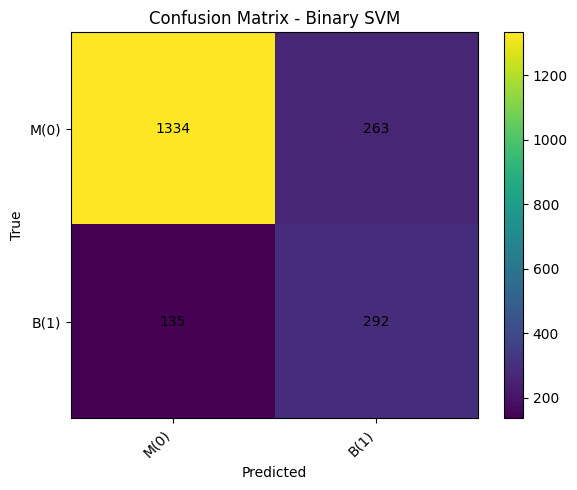

In [ ]:
evaluate_and_plot_binary(y_test_bin, y_pred_bin)

## ROC-AUC

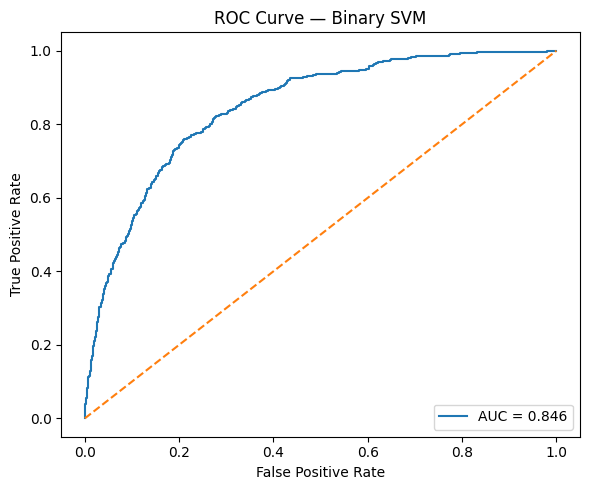

Test ROC-AUC (Binary): 0.8460


In [ ]:
X_te_bin = X_test_all_scaled
y_te_bin = y_test_bin

bin_scores = svm_binary.decision_function(X_te_bin)

fpr, tpr, _ = roc_curve(y_te_bin, bin_scores)
auc_val = roc_auc_score(y_te_bin, bin_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Binary SVM")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Test ROC-AUC (Binary): {auc_val:.4f}")


# Multi-Class Classfication Model

## Define output(y)

In [ ]:
y_mc = skin_df["label"].to_numpy(dtype=int)
class_names_mc = list(le.classes_)

## Split data

In [ ]:
groups = skin_df['lesion_id'].astype(str).fillna(skin_df['image_id'])
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_idx, test_idx = next(gss.split(skin_df, y_mc, groups=groups))

X_img_train, X_img_test = X_img[train_idx], X_img[test_idx]
meta_train,   meta_test = meta[train_idx],   meta[test_idx]
y_train_mc,   y_test_mc = y_mc[train_idx],   y_mc[test_idx]

## Kết hợp metadata và ảnh

In [ ]:
X_train_all = np.hstack([X_img_train, meta_train])
X_test_all  = np.hstack([X_img_test,  meta_test])

## Cross Validation

In [ ]:
C_grid = [0.5, 1, 2, 4, 8]
gamma_grid = ['scale', 0.01, 0.005, 0.001]
param_grid = [(C, g) for C in C_grid for g in gamma_grid]

cv_scores_per_param_mc = { (C,g): [] for (C,g) in param_grid }
idx_tr = np.arange(len(y_train_mc))

for r in range(5):
    tr_idx, val_idx = train_test_split(
        idx_tr, test_size=0.2, random_state=RANDOM_SEED + r, stratify=y_train_mc
    )
    Xtr, Xval = X_train_all[tr_idx], X_train_all[val_idx]
    ytr, yval = y_train_mc[tr_idx], y_train_mc[val_idx]

    sc = StandardScaler().fit(Xtr)
    Xtr_sc  = sc.transform(Xtr)
    Xval_sc = sc.transform(Xval)

    for (C, g) in param_grid:
        clf = SVC(kernel='rbf',
                  C=C, gamma=g,
                  decision_function_shape='ovr',
                  class_weight='balanced',
                  random_state=RANDOM_SEED,
                  probability=True) # Set probability to True
        clf.fit(Xtr_sc, ytr)

        # Use predict_proba instead of decision_function for roc_auc_score
        df = clf.predict_proba(Xval_sc)
        auc_w = roc_auc_score(yval, df, multi_class='ovr', average='weighted')
        cv_scores_per_param_mc[(C,g)].append(auc_w)

param_means_mc = {k: (np.mean(v), np.std(v)) for k,v in cv_scores_per_param_mc.items()}
(best_C_mc, best_gamma_mc), (mean_auc_w, std_auc_w) = max(param_means_mc.items(), key=lambda kv: kv[1][0])
print(f"[Multiclass CV] Best (C, gamma)=({best_C_mc}, {best_gamma_mc}) | AUC(w)={mean_auc_w:.4f} ± {std_auc_w:.4f}")

[Multiclass CV] Best (C, gamma)=(8, 0.01) | AUC(w)=0.9023 ± 0.0059


## Standard Scaler

In [ ]:
scaler_mc = StandardScaler().fit(X_train_all)
X_train_all_scaled = scaler_mc.transform(X_train_all)
X_test_all_scaled  = scaler_mc.transform(X_test_all)
print("Scaled shapes (multiclass):", X_train_all_scaled.shape, X_test_all_scaled.shape)

Scaled shapes (multiclass): (7991, 158) (2024, 158)


## Train model

In [ ]:
svm_multi_class = SVC(kernel='rbf',
                      C=best_C_mc, gamma=best_gamma_mc,
                      decision_function_shape='ovr',
                      class_weight='balanced',
                      random_state=RANDOM_SEED)
svm_multi_class.fit(X_train_all_scaled, y_train_mc)

SVC(C=8, class_weight='balanced', gamma=0.01, random_state=42)

## Evaluation

In [ ]:
y_pred_mc = svm_multi_class.predict(X_test_all_scaled)

In [ ]:
def evaluate_and_plot_multi_class(y_true, y_pred, class_names, title='Confusion Matrix - Multiclass SVM'):
    labels_fixed = list(range(len(class_names)))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=labels_fixed, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, aspect='auto')
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha='right')
    plt.yticks(ticks, class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

Accuracy: 0.7391

Classification Report:
              precision    recall  f1-score   support

       akiec     0.4255    0.2985    0.3509        67
         bcc     0.3762    0.4222    0.3979        90
         bkl     0.5097    0.5432    0.5259       243
          df     0.1250    0.0556    0.0769        18
         mel     0.4746    0.4746    0.4746       236
          nv     0.8694    0.8922    0.8807      1336
        vasc     0.5000    0.0294    0.0556        34

    accuracy                         0.7391      2024
   macro avg     0.4686    0.3880    0.3946      2024
weighted avg     0.7307    0.7391    0.7307      2024



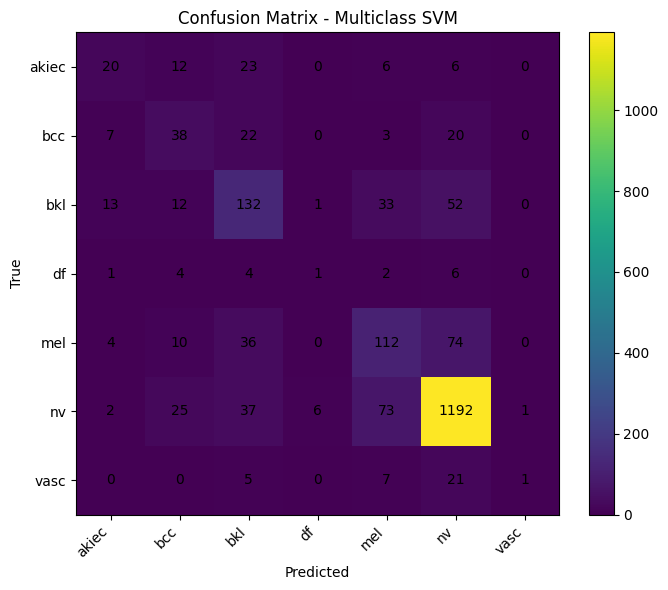

In [ ]:
evaluate_and_plot_multi_class(y_test_mc, y_pred_mc, class_names_mc)

# Save models

In [ ]:
import joblib

save_dir = "/content/drive/MyDrive/Capstone 1 Data/"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(svm_binary, os.path.join(save_dir, 'svm_binary_model.joblib'))
joblib.dump(scaler_bin, os.path.join(save_dir, 'scaler_binary.joblib'))

joblib.dump(svm_multi_class, os.path.join(save_dir, 'svm_multi_class_model.joblib'))
joblib.dump(scaler_mc, os.path.join(save_dir, 'scaler_multi_class.joblib'))

print(f"Models and scalers saved to: {save_dir}")

Models and scalers saved to: /content/drive/MyDrive/Capstone 1 Data/
